# Pipeline Construction

In [1]:
from dao import DataAccess

In [2]:
# Loading Data
import operator

X = DataAccess.as_dataframe()
y = X["labels"].apply(operator.itemgetter("alcohol"))

### Importing Models

We're going to try three standards to build models. `SVM`, `LR`, `RF` to create baselines to beat.

In [3]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#### Importing Pipeline Class 

In [4]:
from pipelines.alcohol import AlcoholPipeline
help(AlcoholPipeline)

Help on class AlcoholPipeline in module pipelines.alcohol:

class AlcoholPipeline(builtins.object)
 |  Methods defined here:
 |  
 |  __init__(self, time_features=None, lsi=False)
 |      :param time_features: default(["dayofweek", "hour", "hourofweek"])
 |      :param lsi: if true, includes the TruncatedSVD() piece
 |  
 |  feature_agepipe(self)
 |      :return: UserAgeMonths
 |  
 |  feature_textpipe(self)
 |      :return: Pipeline(ItemGetter -> TfidfVectorizer -> TruncatedSVD)
 |  
 |  feature_timepipe(self)
 |      :return: Pipeline(ItemGetter -> Timestamp2DatetimeIndex -> DatetimeIndexAttr)
 |  
 |  feature_userpipe(self)
 |      :return: Pipeline(UserGeoVectorizer)
 |  
 |  features(self)
 |      :return: FeatureUnion([
 |          ("text", Pipeline(textpipe)),
 |          ("user", Pipeline(userpipe)),
 |          ("time", Pipeline(timepipe)),
 |          ("age", Pipeline(agepipe)),
 |      ])
 |  
 |  pipeline(self, clf)
 |      :param clf: sklearn.classifer
 |      :return: Pip

#### Using Latent Semantic Indexing

In [ ]:
%%time
clf = AlcoholPipeline(lsi=True).pipeline(LogisticRegression())
clf.fit_transform(X, y)

#### Using only TFIDF Normalization

In [ ]:
%%time
clf = AlcoholPipeline().pipeline(LogisticRegression())
clf.fit_transform(X)

### REMOVE

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [27]:
%%time
clf = AlcoholPipeline().pipeline(clf=RandomForestClassifier(
        n_estimators=100,
        max_depth=100
    ))
clf.fit(X, y)

CPU times: user 4.58 s, sys: 16.3 ms, total: 4.6 s
Wall time: 4.6 s


In [28]:
clf.named_steps.keys()

dict_keys(['clf', 'features', 'exploder'])

In [29]:
accuracy_score(y, clf.predict(X))

0.99842022116903628

In [30]:
confusion_matrix(y, clf.predict(X))

array([[ 892,    5],
       [   0, 2268]])

### REMOVE ABOVE

Look at that performance! Yikes. Hopefully it'll be better when we run this code on **High Performace Computing** at NYU.

## Generating Train-Test Split and Learning Curves

The code for this comes from [Plotting Learning Curves](http://scikit-learn.org/stable/auto_examples/plot_learning_curve.html) by sklearn.

In [31]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cross_validation
from sklearn.learning_curve import learning_curve


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="accuracy")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [32]:
cv = cross_validation.ShuffleSplit(
    len(y), n_iter=20, test_size=0.2, random_state=0
)

# Learning Curves

In [49]:
import seaborn as sns

sns.set_style("darkgrid")

#### Logistic Regression

With sufficiently low variance we'll see that without tuning

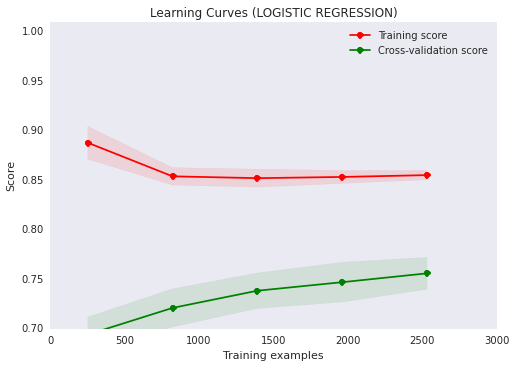

CPU times: user 2.65 s, sys: 351 ms, total: 3.01 s
Wall time: 1min 7s


In [50]:
%%time
title = "Learning Curves (LOGISTIC REGRESSION)"
estimator = AlcoholPipeline().pipeline(LogisticRegression())
plot_learning_curve(estimator, title, AlcoholPipeline()._exploder.fit_transform(X), y, (0.7, 1.01), cv=cv, n_jobs=4)
plt.show()

#### LinearSVC

Variance is really high...

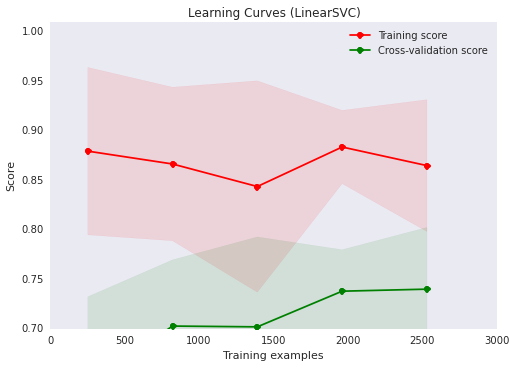

CPU times: user 2.68 s, sys: 410 ms, total: 3.09 s
Wall time: 1min 10s


In [51]:
%%time
title = "Learning Curves (LinearSVC)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
estimator = AlcoholPipeline().pipeline(LinearSVC(
        C=1
    ))
plot_learning_curve(estimator, title, AlcoholPipeline()._exploder.fit_transform(X), y, (0.7, 1.01), cv=cv, n_jobs=4)
plt.show()

#### RandomForests

Notice how well it gets the training data, I feel like this has the most room to improve.

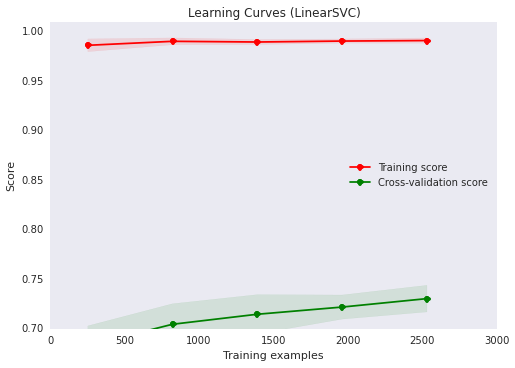

CPU times: user 2.71 s, sys: 356 ms, total: 3.06 s
Wall time: 1min 12s


In [52]:
%%time
title = "Learning Curves (LinearSVC)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
estimator = AlcoholPipeline().pipeline(
    RandomForestClassifier()
    )
plot_learning_curve(estimator, title, AlcoholPipeline()._exploder.fit_transform(X), y, (0.7, 1.01), cv=cv, n_jobs=4)
plt.show()

This is just another one to show that even with a bit of tuning, and falling training score, CV score is still pretty good.

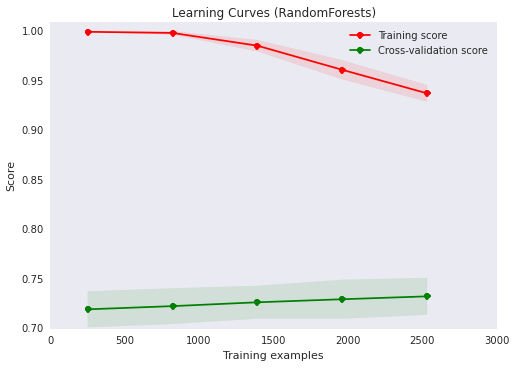

CPU times: user 2.78 s, sys: 468 ms, total: 3.25 s
Wall time: 2min 2s


In [53]:
%%time
title = "Learning Curves (RandomForests)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
estimator = AlcoholPipeline().pipeline(
    RandomForestClassifier(
        n_estimators=200,
        max_depth=50)
    )
plot_learning_curve(estimator, title, AlcoholPipeline()._exploder.fit_transform(X), y, (0.7, 1.01), cv=cv, n_jobs=4)
plt.show()